In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

In [2]:
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
NUM_DIGITS = 10
NUM_SAMPLES = 1024

### Create some data

In [5]:
def binary_encode(i, num_digits):
    """returns values in MSB 0 bit numbering order, i.e the right most bit is the most significant"""
    return np.array([i >> d & 1 for d in range(num_digits)])

In [6]:
x = np.array([binary_encode(x, NUM_DIGITS) for x in range(1,NUM_SAMPLES)])
x

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [7]:
# understand the binary creation logic
i=15
for d in range(NUM_DIGITS):
    print(d, i >> d, i >> d & 1)

0 15 1
1 7 1
2 3 1
3 1 1
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0


In [8]:
x[14]

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

In [9]:
def fizz_buzz_encode(i):
    if   i % 15 == 0: return np.array([0, 0, 0, 1])
    elif i % 5  == 0: return np.array([0, 0, 1, 0])
    elif i % 3  == 0: return np.array([0, 1, 0, 0])
    else:             return np.array([1, 0, 0, 0])

In [10]:
def fizz_buzz_text(i):
    if   i % 15 == 0: return 'Fizzbuzz'
    elif i % 5  == 0: return 'buzz'
    elif i % 3  == 0: return 'Fizz'
    else:             return str(i)

In [11]:
# create a text based version of the encoder to verify - also an actual answer to the fizzbuzz problem.
[fizz_buzz_text(x) for x in range(1,31)]

['1',
 '2',
 'Fizz',
 '4',
 'buzz',
 'Fizz',
 '7',
 '8',
 'Fizz',
 'buzz',
 '11',
 'Fizz',
 '13',
 '14',
 'Fizzbuzz',
 '16',
 '17',
 'Fizz',
 '19',
 'buzz',
 'Fizz',
 '22',
 '23',
 'Fizz',
 'buzz',
 '26',
 'Fizz',
 '28',
 '29',
 'Fizzbuzz']

In [12]:
y = np.array([fizz_buzz_encode(x) for x in range(1,NUM_SAMPLES)])
y

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0]])

In [13]:
# convert to tensors
t_x = torch.tensor(x,dtype=torch.float).unsqueeze(1)
t_y = torch.tensor(y).unsqueeze(1)

In [14]:
print(t_y.dtype)
t_y.shape

torch.int64


torch.Size([1023, 1, 4])

In [15]:
print(t_x.dtype)
t_x.shape

torch.float32


torch.Size([1023, 1, 10])

In [105]:
# new model with RNN layer
class MyModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.linear2 = nn.Linear(10,32)
        self.rnn = nn.LSTM(32,32,2,batch_first=True)
        self.linear3 = nn.Linear(32,4)
        self.do = nn.Dropout(0.1)
    
    def forward(self,input):
   
        x = torch.relu(self.linear2(input))
        x = self.do(x)
        x, h = self.rnn(x)
        return self.linear3(x)
    

In [17]:
# recreation of original for comparison purposes
class MyOriginalModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.linear1 = nn.Linear(10,100)    
        self.linear2 = nn.Linear(100,100)
        self.linear3 = nn.Linear(100,4)
    
    def forward(self,input):
   
        x = torch.relu(self.linear1(input))
        x = torch.relu(self.linear2(x))
    
        return self.linear3(x)
    

In [247]:
model =MyModel()
model

MyModel(
  (linear2): Linear(in_features=10, out_features=32, bias=True)
  (rnn): LSTM(32, 32, num_layers=2, batch_first=True)
  (linear3): Linear(in_features=32, out_features=4, bias=True)
  (do): Dropout(p=0.1, inplace=False)
)

In [248]:
# using a pytorch optimiser
optimiser = optim.Adam(model.parameters(), lr=1e-3)

In [249]:
# check the model can process the data
pred = model(t_x)
pred.shape

torch.Size([1023, 1, 4])

In [250]:
#check the loss function will function with the tensors
loss_BCELL = nn.BCEWithLogitsLoss()
loss_BCELL(pred,t_y.float())

tensor(0.6889, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [251]:
# shufffle the indices
shuffled_indices = torch.randperm(t_x.shape[0])

In [252]:
# split using the cut off above into train, validation and test sets
train_x, valid_x, test_x = t_x[shuffled_indices].split_with_sizes([920,53,50])
train_y, valid_y, test_y = t_y[shuffled_indices].split_with_sizes([920,53,50])

In [253]:
print(train_x.shape[0], valid_x.shape[0], test_x.shape[0])

920 53 50


### Training Loop

In [254]:
# function to perform training
def training_loop(epochs, optimiser, model, loss_fn, x,y, vx, vy, batch_size):
    model.cuda()  # move model to GPU
    val_losses=[]
    train_losses=[]
    
    for epoch in range(1, epochs+1):
        #shuffle the inputs each epoch
        shuffled_indexes = torch.randperm(x.shape[0])
       
        #run in batches (not really needed for a data set this size but general good practice)
        for bs in range(0,x.shape[0],batch_size):
            
            batch_indices= shuffled_indexes[bs:bs+batch_size] # select a batch size number of shuffled indices
            batch = x[batch_indices].cuda() # select a batch of samples and move to the GPU
            target = y[batch_indices].cuda()

            # perform the forward and back passes through the network
            pred = model(batch)
            loss_train = loss_fn(pred,target.float())
            

            optimiser.zero_grad()
            loss_train.backward()
            optimiser.step()

        if epoch == 1 or epoch % 1000 ==0:
            loss_float = float(loss_train)
            
            # not necessary for a model this size but good practice to prevent gradient accumulation of
            # validation set
            with torch.no_grad():
                v_pred = model(vx.cuda())
                loss_valid = float(loss_fn(v_pred, vy.cuda().float()))
                
                v_res = torch.argmax(torch.softmax(v_pred, dim=2),axis=2).cpu().numpy()
                v_actual = torch.argmax(vy,axis=2).numpy()
                
                acc = (np.sum(v_res == v_actual))/len(v_actual)
              
            
            print(f'Epoch: {epoch} Training Loss: {loss_float} Valid Loss: {loss_valid} Valid Acc:{acc}')

            val_losses.append(loss_valid)
            train_losses.append(loss_train)
            
    return train_losses, val_losses

        

In [255]:
%%time
tl, vl = training_loop(5000,optimiser,model,loss_BCELL,train_x,train_y,valid_x, valid_y,256)

Epoch: 1 Training Loss: 0.68500155210495 Valid Loss: 0.682931125164032 Valid Acc:0.5471698113207547
Epoch: 1000 Training Loss: 0.24494090676307678 Valid Loss: 0.2851600646972656 Valid Acc:0.6792452830188679
Epoch: 2000 Training Loss: 0.03305377811193466 Valid Loss: 0.1151161640882492 Valid Acc:0.9433962264150944
Epoch: 3000 Training Loss: 0.02504267916083336 Valid Loss: 0.047133833169937134 Valid Acc:0.9433962264150944
Epoch: 4000 Training Loss: 0.025609895586967468 Valid Loss: 0.02006249502301216 Valid Acc:1.0
Epoch: 5000 Training Loss: 0.007079674396663904 Valid Loss: 0.07621054351329803 Valid Acc:0.9433962264150944
CPU times: user 50.5 s, sys: 747 ms, total: 51.2 s
Wall time: 51.1 s


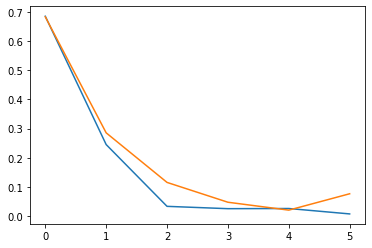

In [256]:
plt.plot(tl)
plt.plot(vl)

### Review Results

In [257]:
model.eval()

MyModel(
  (linear2): Linear(in_features=10, out_features=32, bias=True)
  (rnn): LSTM(32, 32, num_layers=2, batch_first=True)
  (linear3): Linear(in_features=32, out_features=4, bias=True)
  (do): Dropout(p=0.1, inplace=False)
)

In [258]:
# get the raw predictions
raw_preds = torch.softmax(model(test_x.cuda()),2).cpu()

In [259]:
# convert to multiclass code
preds = torch.argmax(raw_preds, axis=2).numpy()

In [260]:
actuals = torch.argmax(test_y, axis=2).numpy()

In [261]:
# check raw accuracy
acc = np.sum(preds == actuals)
print(acc, acc/50)

50 1.0


In [262]:
# examine the elements that were wrong
error_indexs = np.where((preds == actuals)== False)[0]

In [263]:
error_indexs

array([], dtype=int64)

In [264]:
print('number\t actual\t pred\t actual text')
back_convert = torch.tensor([1.,2.,4.,8.,16.,32.,64.,128.,256.,512.])
for e in error_indexs:
    int_val = int((back_convert @ test_x[e].T).item())
    print(int_val,'\t', actuals[e][0],'\t', preds[e][0],'\t', fizz_buzz_text(int_val))

number	 actual	 pred	 actual text


In [265]:
all_raw_preds = torch.softmax(model(t_x.cuda()),2).cpu()
all_preds = torch.argmax(all_raw_preds, axis=2).numpy()

In [266]:
all_actuals = torch.argmax(t_y, axis=2).numpy()

In [267]:
# check raw accuracy
all_acc = np.sum(all_preds == all_actuals)
print(all_acc, all_acc/1024)

1022 0.998046875


In [268]:
# examine the elements that were wrong
all_error_indexs = np.where((all_preds == all_actuals)== False)[0]
all_error_indexs

array([798])

In [269]:
print('number\t actual\t pred\t actual text')

# for conversion back to decimal
back_convert = torch.tensor([1.,2.,4.,8.,16.,32.,64.,128.,256.,512.])

for e in all_error_indexs:
    int_val = int((back_convert @ t_x[e].T).item()) # convert to decimal
    print(int_val,'\t', all_actuals[e][0],'\t', all_preds[e][0],'\t', fizz_buzz_text(int_val))

number	 actual	 pred	 actual text
799 	 0 	 1 	 799


In [273]:
torch.softmax(all_raw_preds[798],dim=1)

tensor([[0.1881, 0.4564, 0.1777, 0.1777]], grad_fn=<SoftmaxBackward>)